In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [3]:
color_pal = sns.color_palette()
color_pal

[(0.0, 0.5607843137254902, 0.8352941176470589),
 (0.9882352941176471, 0.30980392156862746, 0.18823529411764706),
 (0.8980392156862745, 0.6823529411764706, 0.2196078431372549),
 (0.42745098039215684, 0.5647058823529412, 0.30980392156862746),
 (0.5450980392156862, 0.5450980392156862, 0.5450980392156862),
 (0.5058823529411764, 0.058823529411764705, 0.48627450980392156)]

# Outline

- Outlier analysis
- Forecasting horizon
- Time Series cross validation
- Lag Features
- Predicting the Future

In [4]:
df = pd.read_csv("./data/PJME_hourly.csv")
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

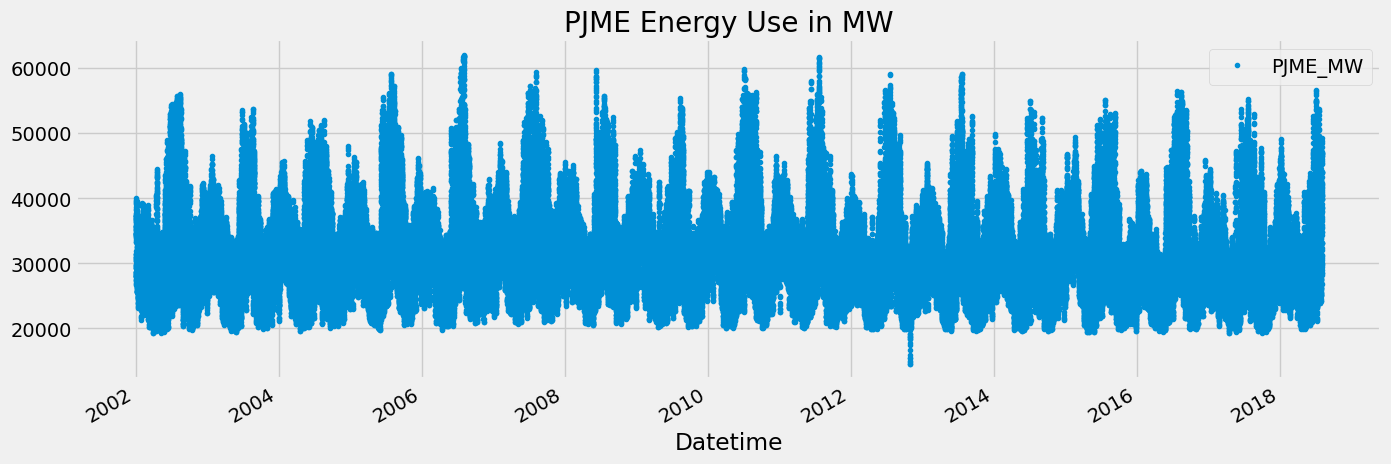

In [5]:
df.plot(style=".", 
        figsize=(15, 5), 
        color=color_pal[0], 
        title="PJME Energy Use in MW"
        )

# 1. Outlayer Analysis and removal

<Axes: ylabel='Frequency'>

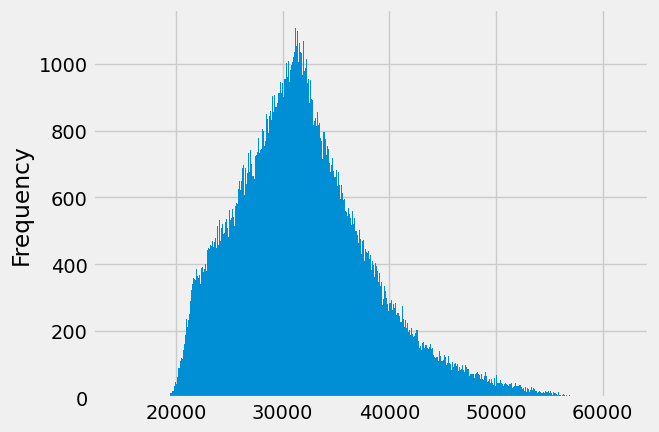

In [6]:
df["PJME_MW"].plot(kind="hist", bins=500)

<Axes: xlabel='Datetime'>

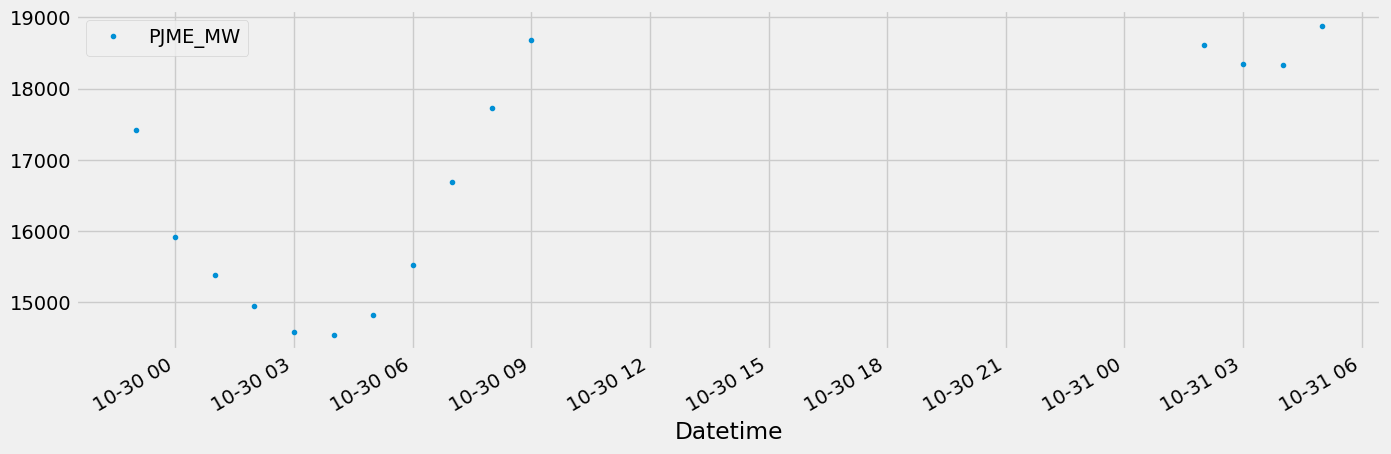

In [7]:
df.query("PJME_MW < 19_000").plot(figsize=(15, 5), style=".")

In [8]:
df = df.query("PJME_MW > 19_000").copy()

# Reviewing: Train / Test Split

# 1. Time Series Cross Validation

In [15]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

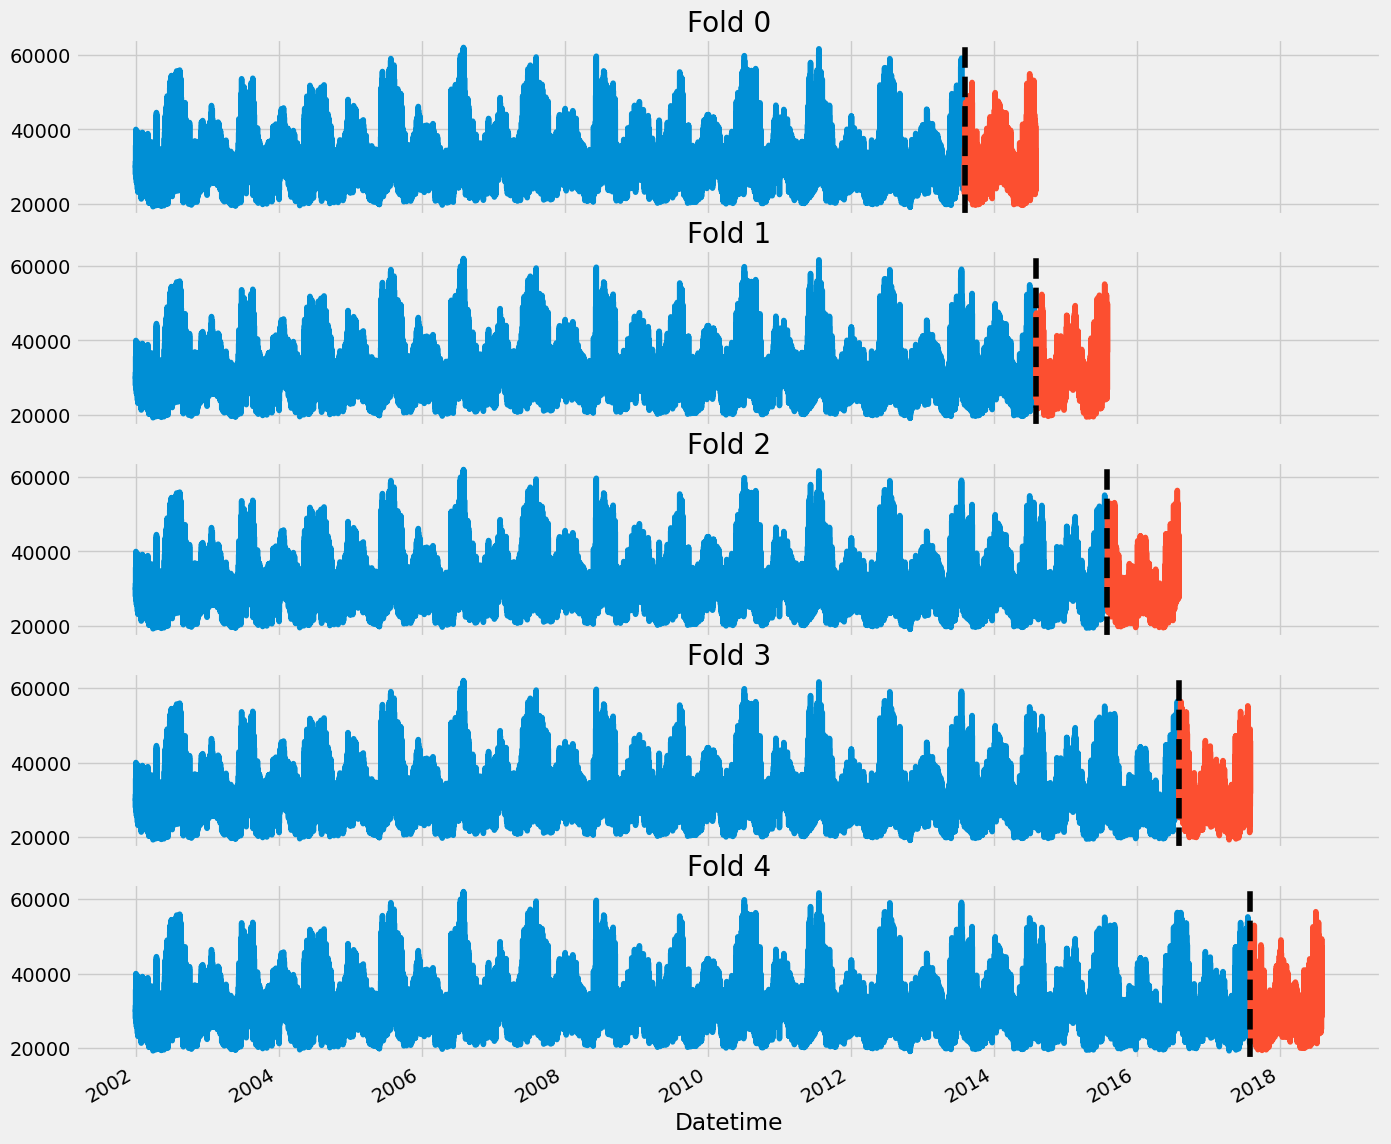

In [16]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train["PJME_MW"].plot(ax=axs[fold],
                        label="Trainig Set",
                        title=f"Fold {fold}")
    test["PJME_MW"].plot(ax=axs[fold],
                    label="Test Set")  
    axs[fold].axvline(test.index.min(), color="k", linestyle="--")                  
    fold += 1

plt.show()

# 2. Forecasting Horizon



In [17]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    
    return df

df = create_features(df)

# 3. Lag Features
- What was the target (x) days in the past.

In [18]:
def add_lags(df):
    target_map = df["PJME_MW"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    
    return df

In [19]:
df = add_lags(df)

### Train Using Cross Validation

In [14]:
df.head()

,PJME_MW,lag1,lag2,lag3
Datetime,,,,
2002-12-31 01:00:00,26498.0,30393.0,NaN,NaN
2002-12-31 02:00:00,25147.0,29265.0,NaN,NaN
2002-12-31 03:00:00,24574.0,28357.0,NaN,NaN
2002-12-31 04:00:00,24393.0,27899.0,NaN,NaN
2002-12-31 05:00:00,24860.0,28057.0,NaN,NaN


In [20]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ["dayofyear", "hour", "dayofweek", "quarter", "month", "year", "lag1", "lag2", "lag3"]
    TARGET = "PJME_MW"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, 
                           booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective="reg:linear",
                           max_depth=3, 
                           learning_rate=0.01, 
                           )
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[20:37:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[456]	validation_0-rmse:3349.18480	validation_1-rmse:3761.64093
[20:37:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rms

In [22]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold scores: {scores}")

Score across folds 3750.6406
Fold scores: [3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.3608331481823, 3996.298054855067]


# 4. Predicting the Future

- Retrain on all data
- To Predict the future we need an empty dataframe for future date ranges
- Run those dates through our feature creation code + lag creation

In [23]:
# Retrain on all data
df = create_features(df)

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, 
                        booster='gbtree',
                        n_estimators=500,
                        early_stopping_rounds=50,
                        objective="reg:linear",
                        max_depth=3, 
                        learning_rate=0.01)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[21:06:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[499]	validation_0-rmse:3454.55122


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [27]:
# Create future dataframe
future = pd.date_range("2018-08-03", "2019-08-01", freq="1h")
future_df = pd.DataFrame(index=future)
future_df["isFuture"] = True
df["isFuture"] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [45]:
future_w_features = df_and_future.query("isFuture").copy()

In [46]:
future_w_features

,PJME_MW,lag1,lag2,lag3,hour,dayofweek,quarter,month,year,dayofyear,isFuture
2018-08-03 00:00:00,NaN,33539.0,32094.0,31695.0,0,4,3,8,2018,215,True
2018-08-03 01:00:00,NaN,30781.0,29503.0,29128.0,1,4,3,8,2018,215,True
2018-08-03 02:00:00,NaN,29015.0,27712.0,27373.0,2,4,3,8,2018,215,True
2018-08-03 03:00:00,NaN,27884.0,26535.0,26233.0,3,4,3,8,2018,215,True
2018-08-03 04:00:00,NaN,27223.0,25870.0,25643.0,4,4,3,8,2018,215,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,46912.0,39352.0,40243.0,20,2,3,7,2019,212,True
2019-07-31 21:00:00,NaN,45985.0,38699.0,39183.0,21,2,3,7,2019,212,True
2019-07-31 22:00:00,NaN,44094.0,37346.0,37759.0,22,2,3,7,2019,212,True
2019-07-31 23:00:00,NaN,40666.0,34555.0,34641.0,23,2,3,7,2019,212,True


### Predict the future

In [47]:
future_w_features["pred"] = reg.predict(future_w_features[FEATURES])

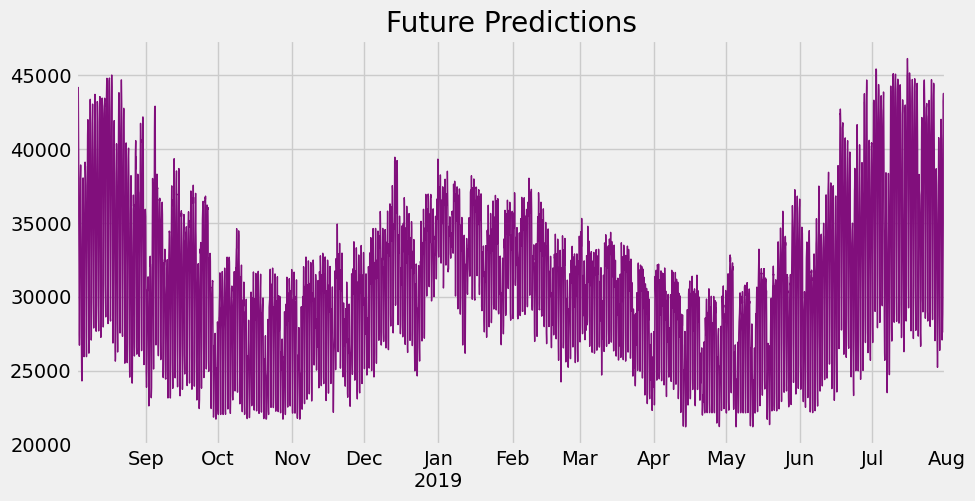

In [50]:
future_w_features["pred"].plot(figsize=(10, 5),
                               color=color_pal[5],
                               ms=1, 
                               lw=1, 
                               title="Future Predictions")
plt.show()

# Bonus: Saving Model For Later

In [51]:
reg.save_model("model.json")

In [52]:
!ls -lh

total 1.7M
drwxr-xr-x 1 Enric 197609    0 Mar 24 00:47 data
-rw-r--r-- 1 Enric 197609 572K Mar 24 21:17 model.json
-rw-r--r-- 1 Enric 197609 628K Mar 24 00:01 time_series_forecasting.ipynb
-rw-r--r-- 1 Enric 197609 441K Mar 24 02:38 time_series_forecasting_2_(advanced_mehtods).ipynb
drwxr-xr-x 1 Enric 197609    0 Mar 24 00:06 venv


In [53]:
reg_new = xgb.XGBRegressor()
reg_new.load_model("model.json")

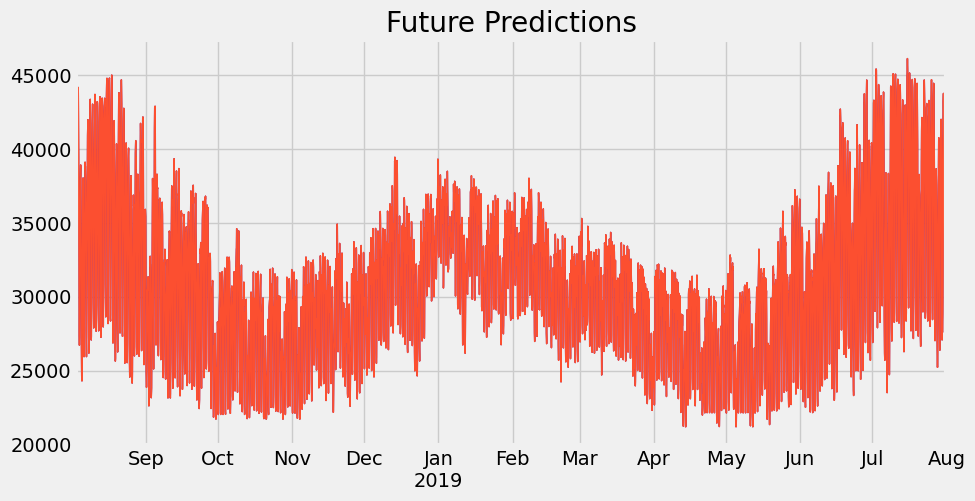

In [54]:
future_w_features["pred_new"] = reg_new.predict(future_w_features[FEATURES])
ax = future_w_features["pred"].plot(figsize=(10, 5),
                                    color=color_pal[5],
                                    ms=1, 
                                    lw=1, 
                                    title="Future Predictions")
future_w_features["pred_new"].plot(ax=ax, color=color_pal[1], ms=1, lw=1)
plt.show()